<a href="https://colab.research.google.com/github/christianio123/Projects/blob/main/PneumoniaClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Image Analysis - Pneumonia X-Ray Classification

## Project
The project will be focused on medical imaging, specifically, using deep learning for medical image analysis of pneumonia using radiography. Medical imaging provides spatially resolved information from within the human body. Medical imaging is completed using multiple imaging techniques, including but not limited to, (a) radiography, (b) magnetic resonance imaging, (c) ultrasound imaging, and (d) positron emission tomography. Probably the most prevalent is radiography, also known as “X-Ray Imaging”. X-ray imaging is used for a range of situations such as (a) diagnosing of diseases, (b) therapy selection, (c) and surgical procedures. X-rays penetrate the human body and are partially absorbed by anatomical structures. The differently attenuated beams are then detected by a dedicated detector and subsequently converted into an image. When a professional diagnosis an X-ray image, they often want to measure distances. These distances are measured as the number of pixels on a detector, however for the human eye it is highly unlikely to be able to both identify and interpret the pixel distance. 

## Purpose
Pneumonia is one of the most common causes for hospital admissions with about one million adults seeking hospital care per year. Of those one million adults, fifty thousand individuals pass away annually from the pneumonia [1]. Additionally, pneumonia is also a serious complication of coronavirus [2], having affected over 46 million people, and killing over 700 thousand people in the United States since January 2020 [3]. It is safe to assume that if pneumonia is not identified in a timely manner, it has the potential to become life threatening. In a recent experience of my own, my grandfather passed away from COVID-19, particularly, the complications caused by the pneumonia he developed. In the time span from when he contracted COVID-19 and passed away, there were numerous occasions in which our family could not decide a plan of action because a doctor was not there to help interpret vital information from administered tests scans and tests. I believe every family should be able to attain raw data immediately and have the tools to interpret that information without the long-wait time from doctors in which a disease can increase in severity. 

## Dataset
The Pneumonia Detection Challenge (2018) is part of an efforts to develop artificial intelligence (AI) for radiology from the Radiological Society of North America (RSNA) [4]. The challenge uses a dataset with 26,684 X-ray images, of which 20,672 image do not show signs of pneumonia and 6,012 images do show signs of pneumonia. We will use this dataset in an effort to produce a model that will predict whether particular X-ray images show signs of pneumonia or not. My objective is to deepen my understanding of deep learning models using medical image analysis.  

[1] <a href="https://www.thoracic.org/patients/patient-resources/resources/top-pneumonia-facts.pdf" title="Title">
American Thoracic Society – Top 20 Pneumonia Facts – 2019</a>

[2] <a href="https://www.webmd.com/lung/covid-and-pneumonia#1" title="Title">
WebMD – Coronavirus and Pneumonia</a>

[3] <a href="https://covid.cdc.gov/covid-data-tracker/#datatracker-home" title="Title">
Centers for Disease Control and Prevention – COVID Data Tracker</a>

[4] <a href="https://www.rsna.org/education/ai-resources-and-training/ai-image-challenge/rsna-pneumonia-detection-challenge-2018" title="Title">
Radiological Society of North America – Pneumonia Detection Challenge (2018)</a>

## Install Packages and Download Dataset
The project runs from google colab, therefore if others want to run this notebook at it's contents the following packages are necessary. In addition, a Kaggle API key is needed by the individual running this notebook.

In [1]:
!pip install -U -q kaggle==1.5.8

     |████████████████████████████████| 59 kB 2.4 MB/s 


In [2]:
 from google.colab import files
 files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chrisiortiz","key":"7b31dac5a7dcf065cee8910f3addd71c"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!mkdir Pneumonia/

In [7]:
cd Pneumonia/

/content/Pneumonia


In [8]:
!mkdir Processed/

In [9]:
!kaggle competitions download -c rsna-pneumonia-detection-challenge

 99% 3.64G/3.66G [00:27<00:00, 157MB/s]
100% 3.66G/3.66G [00:27<00:00, 142MB/s]


In [ ]:
! unzip rsna-pneumonia-detection-challenge.zip

In [ ]:
!pip install pytorch-lightning

In [12]:
! pip install pydicom 

     |████████████████████████████████| 2.0 MB 5.1 MB/s 


In [13]:
!pip install torchmetrics

## Preprocessing

In [14]:
from pathlib import Path # path handling
import pydicom # reading dicom files
import numpy as np # storing images
import cv2 # resizing images
import pandas as pd # read labels
import matplotlib.pyplot as plt # visialization
from tqdm.notebook import tqdm # progress bar

We will start by reading the provided csv file

In [15]:
labels = pd.read_csv("stage_2_train_labels.csv")

In [16]:
labels.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


The dataset consists of a unique patient id, the coordinates where pnemonia procures, and a binary target variable that indicates whether pnemonia is present in the given x-ray image or not. PatientId may occur multiple times in the dataset because different pneumonia spots are handled indivually. For our classification task, we remove those duplicates because we are interested in the binary label only. As an example index 4 and 5 correspond to the same image. To do so we simply remove our labels variable with the result from the following variable. 

In [17]:
labels = labels.drop_duplicates("patientId")

This deletes all rows whose contents have already occured in the specified column ("patientId"). The first rooth path will take a path object to our train images. The save_path variable takes a path object to a place where we want to store our files. 

In [18]:
ROOT_PATH = Path("stage_2_train_images/")
SAVE_PATH = Path("Processed/")

Now it is time to to look at our example images. To do so, we trade a 3x3 subplot to visualize 9 x-ray images paired with their corresponding labels. We define our loop counting variable C at 0. Then we code a double nested for loop to begin reading the files. First we have to extract the patient ID from our latest dataframe. To do so, we create a variable patient_id. We use .iloc[] with the counting variable C to get the row. We then create a path to the diacom file of the patient id. To do this we create dcm_path and concatonate ROOT_PATH with the patiend_id. Then we add the file extension to the path by over riding the diacom path by calling the with suffix function provided by the path library. Now we have a full path to the diacom file and can read it. Additionally, as we are only interested in the pixel arrays we can directly extract the pixel array. We can store up the label or the target variable for this particular image by creating a variable and extracting it from our labels dataframe. Then we visualize the image and use the corresponding label as its title. So we get the current axis object using .imshow on our image. Additionally we set the color map, being able to choose between gray or bone. Then we set the title of the corresponding image by getting our current axis object and calling the function ser_title() where we pass in the label. Then we increase our C count variable as the last command in the cell.

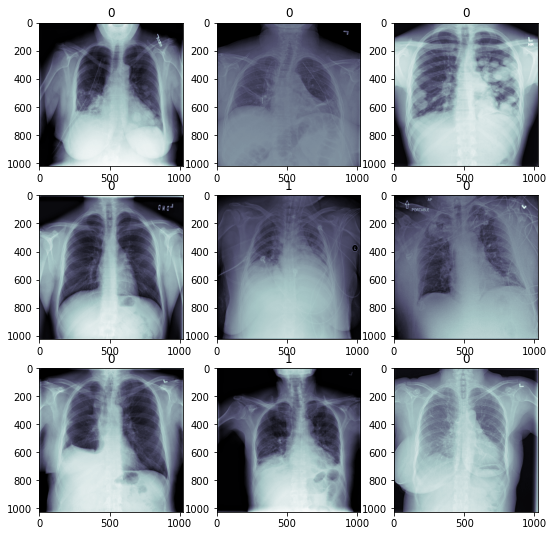

In [19]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))
c = 0
for i in range(3):
    for j in range(3):        
        patient_id = labels.patientId.iloc[c]
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        dcm = pydicom.read_file(dcm_path).pixel_array
        
        label = labels["Target"].iloc[c]
        
        axis[i][j].imshow(dcm, cmap = "bone")
        axis[i][j].set_title(label)
        c += 1

We get a 3x3 print showing X-Ray images. We can see that the central images of the middle and lower line have a postisive label which means that those patients suffer or suffered from pnemonia. Now it is time to load, and preprocess our data. We look over all patient Id's and standardize and resize those images before storing them in their corresponding directory according to their labels. Additionally, we compute mean and standard deviation of those images. 

At first we define our sums and sums_squared variables and initially set them to 0. THen we define a loop iterating through all patient ID's. To decide if the current image belongs to the training data or is used as a validation file, we can use the enumerate function. By getting access to the loop counting variable C, we can put all images from X-ray number 24,000 in the validation split. As our goal is standardization, we directly divide the pixel_array by 255. Next, as the original images of shape 1,024 x 1,024 are way too large to be handled, we resize them to a smaller shape of 224 squared. To use less space when storing the images, we convert them to float16. We then define a variable dcm_array, and call cv2.resize() plus our pixel array as our first argument and 224 squared to the second block. Then it is quickly converted to float16. Now that we have successfully preprocessed our current X-ray image we should store its label in a variable called label. We can reused the code from above to achieve this. Then we decide whether we want to store our current image in the train or validation directory by defining a new variable, train_or_val, and assigning it the string "train" if our count variable C is less than 24000 or else we assign the string "va". To save our preprocessed files in the correct directory, we can define a safe path variable which points to the correct place. We will define "current_save_path" and assign it the predefined SAVE_PATH followed by train_or_val string and finally the class label. Please note that PATH cannot handle integers and therefore we convert our label into a string. As we did not create this path before, we need to make sure that it actually exists therefore we access our current_save_path variable and call the make directory function, or .mkdir function, where we pass parents equals equals true. This guarantees that .mkdir creates all parent paths to the file. For the second argument, exists_ok, we also pass true. This prevents the function from throwing an error if the path already exists. Now we can use np.save, where we first pass in current_save_path followed by patient id, which will act as the file name. The second argument is our preprocessed dcm_array. The last steps here will be to update the sums and sums_squared variables. Before doing so, we need to compute normalizer which takes the number of pixels in each image. 

In our case, this is simply 224x224 pixels. Next we need to make sure we only updates sums and sums_squared while we are on our train split. It is crucial that the validation data has absolutely no influence  on the training set. Otherwise our model might also overfit on the validation data which basically means that we have no way to validate and evaluate our model properly. Now we can finally update are sums variable by adding the sum of the current dcm_array divided by the normalizer. To update sums_squared, we at first square all pixels within our dcm_array, next we compute the sum of those squared pixels and finally divide it by the normalizer.

In [20]:
sums = 0
sums_squared = 0

for c, patient_id in enumerate(tqdm(labels.patientId)):
    dcm_path = ROOT_PATH/patient_id # Create a path to the dcm file
    dcm_path = dcm_path.with_suffix(".dcm") # And add the .dcm suffix
    
    # Read the dicom file with pydicom and standardize the array
    dcm = pydicom.read_file(dcm_path).pixel_array / 255
    
    # Resize the image as 1024x1024 is way to large to be handled by Deep Learning models at the moment
    # We'll use the shape 224x224
    # In order to use less space when storing the image we convert to float16
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)
    
    # Retrieve tje corresponding label
    label = labels.Target.iloc[c]
    
    # 4/5 train split, 1.5 val split
    train_or_val = "train" if c < 2400 else "val"
    
    current_save_path = SAVE_PATH/train_or_val/str(label) # Define save path and create if necessary
    current_save_path.mkdir(parents = True, exist_ok = True) 
    np.save(current_save_path/patient_id, dcm_array) # Save the array in the corresponding directory
    
    normalizer = dcm_array.shape[0] * dcm_array.shape[1] # Normalize sum of image
    if train_or_val == 'train': # Only use train data to compute dataset statistics
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (np.power(dcm_array, 2).sum()) / normalizer

  0%|          | 0/26684 [00:00<?, ?it/s]

The last step remaining is to convert our sums and sums_squared variables into mean and standard deviation respectively. We can get the mean by simply dividing our sums variable by the number of images in our training data (2400 images). To compute the standard deviation, we take the square root of sum squared divided by 24000, and then subtract the squared mean from this result. 

In [21]:
mean = sums / 24000
std = np.sqrt(sums_squared / 24000 - (mean**2))

The computed mean and standard deviation will be used to normalize the dataset.

In [22]:
mean, std

(0.04904597483524674, 0.16692448725186196)

## Data Loading

In [23]:
import torch # model creation
import torchvision # dataloader creation
from torchvision import transforms 
import torchmetrics # metric computation
import pytorch_lightning as pl # training implementation
from pytorch_lightning.callbacks import ModelCheckpoint # checkpoint saving
from pytorch_lightning.loggers import TensorBoardLogger # logging
from tqdm.notebook import tqdm # progress bar for sanity check

We will leverage the dataset folder class from torchvision it'll allow us to simply pass a ROOT directory and returns the dataset with access to all data within the subfolders of the ROOT directory. This dataset returns the data stored in the subdirectories together with the name of the corresponding subdirectory as the label. We create another function defining the files that need should be loaded. Additionally we need to pass a list of the file extensions we want to load to the dataset folder class. In our case, this is simply npy. Finally we pass the transformation sequence for data augmentation and normalization. 

Let us first define the load file function. We create a function named load_file() which accepts a path as its only argument. This function simply needs to load the files specified by the path and then convert it to flow through to float for the training. We set the function to directly return by using np.load(path) and convert it to np.float32. 

In [24]:
def load_file(path):
    return np.load(path).astype(np.float32)

Next, we can define our train and validation transforms. At first we create a variable called train_transforms, which will take the augmentation pipeline for the training dataset. To combine or compose multiple augmentation functions we use transforms.Compose, which accepts a list of multiple transforms. At first we have to convert the numpy array to a torch tensor. To achieve this we can use transforms.ToTensor(). Next we normalize our images by using transforms.Normalize(), this function accepts are precomputed mean and standard deviation as the first and second argument. Finally, we can define our data augmentation pipepile. At first we use RandomAffine which allows to transform, rotate, and scale the images. So we call RandomAffine(), define a tuple for the random rotation caleed degrees in the form of (-5,5). As we want to have random rotations between -5 and 5 degrees. Then we pass translate is equal to (0, 0.05), which creates random translations of max 5 percent, and finally we pass scale from 0.9 to 1.1, which randomly scales from image in that interval. The last augmentation we use are random resized crops. They crop a random portion of the image and then resizes the crop to the desired size. We access them by calling transforms.RandomResizedCrop and pass in the desired image shape. In our case, as we don't want the size of the images to change, we just pass in (224,224). It is crucial that we don't crop away parts of the image which show pnemonia as otherwise we would have to change our label. Therefore we need to make sure our crops contain enough information. We can define the sizes our crops are allowed to have, by using the scale argument. The scale argument expects a tuple where the first element corresponds to the smalled crop size and the second one for the largest. A crop that contains at least 35 percent of the image should be large enough to not crop away any relevant parts. Additionally, we want to feed images that are not cropped at all, and therefore use 1 as the upperbound. 

Next we define our validation transforms. The variable we define is val_transforms, and again we used transforms.Compose(). We don't want to apply test type augmentations, so we only use transforms.ToTensor() and transforms.Normalize. 

In [25]:
train_transforms = transforms.Compose([
    transforms.ToTensor(), # Convert numpy array to tensor
    transforms.Normalize(0.49, 0.248), # Use mean and std from preprocessing
    transforms.RandomAffine(# Data Augmentation
        degrees = (-5,5), translate = (0, 0.5), scale = (0.9, 1.1)),
        transforms.RandomResizedCrop((224,224), scale = (0.35, 1))
])

val_transforms = transforms.Compose([
    transforms.ToTensor(), # Convert numpy array to tensor
    transforms.Normalize(0.49, 0.248) # Use mean and std from preprocessing
])

Finally we create the train and validation datasets. First we define train_dataset and use torchvision.datasets.DatasetFolder() where we first pass in the root directory to our images. Next we pass our load_file function to the loader argument, and also the possible five extensions, in our case npy. Finally we pass our train_transforms pipeline to the transform argument. 

We can simply repeat this procedure for the validation dataset. 

In [26]:
train_dataset = torchvision.datasets.DatasetFolder(
    "Processed/train/",
    loader = load_file, extensions = "npy", transform = val_transforms)

val_dataset = torchvision.datasets.DatasetFolder(
    "Processed/val/",
    loader = load_file, extensions = "npy", transform = val_transforms)

Now it is time to take a look at some augmented images of our trained dataset. We will use a 2x2 subplot matrix for this. We define our figure and axis objects and call plt.subplots where we pass the number of rows and columns. Additionally, let's use a figure size of 9x9. Then we use a double nested for loop in the range of 2 to get access to all axis objects. Instead of using our loop counting variable, we simply choose a random index by using np.random.randint() in the range from 0 to 24000. This simply returns one integer between 0 and 2400. Now we can use this particular random index to extract an X-Ray image and its corresponding label from our trained dataset. Finally, we use i and j to access the current axis object and call imshow() on it to plug the current x-ray image. Please not that the dataset for the class from torchvision automatically appends a channel dimension in front of all other axes. However, as matplotlib cannot handle this, we need to get rid of it by simply indexing it. We use the bone colop map. Then access the current axis object again to set the label as image title. 

We will see the impact of the different augmentations and also that our crop size of 35 percent wasn't too small. Almost 100% of lung area can be seen in all images. 

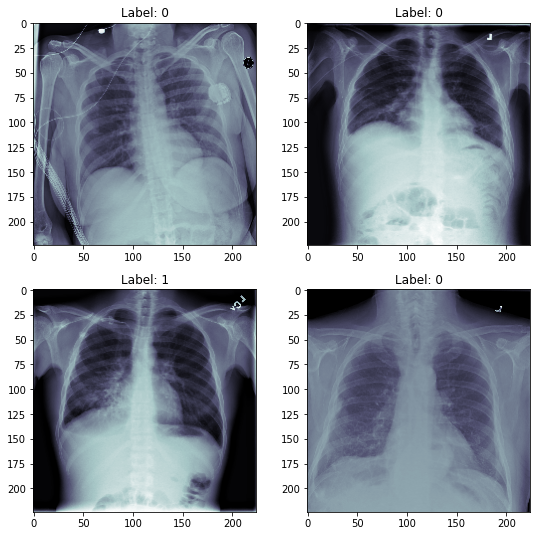

In [27]:
fig, axis = plt.subplots(2,2,figsize = (9,9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0,len(train_dataset))
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap = 'bone')
        axis[i][j].set_title(f"Label: {label}")

Next, we are going to create our train and validation dataloaders, but first we will define a batch size with numbers our system can handle. Then we will define a variable called train_loader, which we assign the data loader from torch.utils.data.DataLoader(), which gets the train_dataset as its first argument, the batch_size as the second argument, the number of workers as its third, and lastly set shuffle equal to true. 

Next we define our validation data loader by simply copying the previous code. We replace trained_dataset with validation_dataset, and set shuffle to false. When validating the model, we don't want to shuffle our data in order to get the deterministic evaluation.

In [28]:
batch_size = 64
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = False)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 2400 train images and 24284 val images


To understand our data a tad but more, we check the distribution of labels to answer the question how many images actually do show signs of pneumonia. We use np.unique on the trained_dataset.targets where our labels are stored followed by return_counts equal to true to get the distribution of labels. We can see that there are many more images without pnemonia as with pneumonia, threfore our dataset is imbalanced. Typically there are three ways to handle imbalanced datasets. 

1) The first possibility is to do nothing. Sometimes this works surprisingly well.

2) A weighted loss function assigns a higher loss to a prediction if the model ever predicts the negative class. 

3) Use oversampling, when using oversampling, the overall goal is to show the network as many samples from class one as from class zero. 

We test to use a weighted loss of three, as there are about three times as many images without pneumonia as there are with. 

In [29]:
np.unique(train_dataset.targets, return_counts=True), np.unique(val_dataset.targets, return_counts=True)

((array([0, 1]), array([1571,  829])), (array([0, 1]), array([19101,  5183])))

## Model Creation

In PyTorch lighting, each model is defined by at least initialization method and formal class method. Additionally, when training the model, we need to define the training step and a function called configure optimizers. 

First we define the complete model class. In our case we can call it PneumoniaModel, typically when working from PyTorch, we can inherit from the Torch.Module class. However, when working when PyTorch lighting, we'll inherit from PyTorchLighting.LightningModule. At first we define an initialization method called __in__, accepting one argument called self. In that initialization function, we typically create or load the model, define optimizers and loss functions and also other metrics. We will use resnet18 as our classification network. We will define a variable called self.model, which we assign the resnet18 network from torchvision.models.resnet18(). However, we need to change the input channels from 3 to 1, and the output of the last fully connecter layer from 1000 to also 1. To do so, we need access to specific layers. 

When printing a model, we get a visualization of its internal structure and all layers. Additionally, we can find out how the individual layers are called as an example, the name of the first convolutional layer is conv1. To see it once more, we need to replace the first convolutional layer, where we change the number of inputs channels from 3 to 1, and also we need to change the fully connected layer where we change out_features from 1000 to 1. 

To do this, we use the name of the first convolutional layer, self.model.conv1, then we can overwrite it by copying the parameters, prepending torch.nn to be able to access the class and finally replace 3 by 1. To change our out features, again we access the corresponding layer, called fc, copy the parameters, preprend torch.nn, and change the out_features to 1. 

Now we will train the optimizer and store it in self.optimizer. We will be using the Adam optimizer, accessed via torch.optim.Adam(). Each optimizer accepts at first the the parameters of the model, accessible via self.model.paramters, and next the initial learning rate, which is in our case 1e-4. Additionally, we can create our loss function and store it in self.loss_fn. We use the binory cross-entropy with logits loss, which can be accessed via torch.nn.BCEWithLogitLoss(). To use the weighted version of this, we can pass the pos_weight argument where we define the weight it should use. Note that pos_weight expects a tensor instead of a scalar. Therefore we simply convert our 3 to a tensor using torch.tensor(). Lastly, we can use accuracy as metrics in self.train_acc accessed via torchmetrics.Accuracy(). The same can be used for the validation function. 

Next is the forward function, we simply train a function called foward. It accepts two arguments, self and the data we want to compute a prediction on. The forward function is responsible for computing the forward pass or prediction. In our case, it simply needs to compute the output of our resnet18 and return the raw prediction. We can use a temporary variable called pred, which stores the output of self.model based on data. Now all we have to do is return the value.

training_step accepts self, current batch, corresponding batch ID as its arguments. First we need to extract the x_ray and corresponding labels from the current batch. Next we need to convert our label variable to type float because PyTorch cannot compute the loss on integers. Now we compute the prediction using our forward function. When using PyTorchLighting, we do not need to call self.forward, but we can simply use self as a function and pass the x_ray images. Remember our predictions are of shape (batch_size, 1) whereas our labels are only of shape batch_size. Therefore we need to remove the second dimension on our predictions. To compute the loss, we will first store loss in a variable and call self.loss_fn(), where we pass the prediction and labels. We can log the loss and batch accuracy. To log something in PyTorch Lighting, we use self.log() function which accepts a unique identifier as its first argument and the corresponding volume as the second one. Additionally we can log our train step accuracy.  Then we simply simply return the loss because based on the volume the training step returns, PyTorch lighting optimizes the model.

Additionally, we can define a function called training_epoch_end which accepts the self argument and outs. The outs argument contains all elements returned by the training step. In our case it returns a list of all losses. This functions defines what happens after the epoch has finished. We want to use it to log the accuracy on the whole dataset. We could also include the validation set here. 

The last function we call is the configure_optimizers function. This function returns a list of all optimizers. Even if there was only a single optimizer, a list will be returned. 

In [30]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self, weight=1):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        # change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))
        
        # simple accuracy computation
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()

    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)[:,0]  # Prediction: Make sure prediction and label have same shape
        loss = self.loss_fn(pred, label)  # Compute the loss
        
        # Log loss and batch accuracy
        self.log("Train Loss", loss)
        self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int()))
        return loss
    
    
    def training_epoch_end(self, outs):
        # After one epoch compute the whole train_data accuracy
        self.log("Train Acc", self.train_acc.compute())
        
        
    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]  # make sure prediction and label have same shape

        loss = self.loss_fn(pred, label)
        
        # Log validation metrics
        self.log("Val Loss", loss)
        self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))
        return loss
    
    def validation_epoch_end(self, outs):
        self.log("Val Acc", self.val_acc.compute())
    
    def configure_optimizers(self):
        return [self.optimizer]



In [31]:
model = PneumoniaModel()  # Instanciate the model

## Trainer

Before we begin training, we need to create a checkpoint callback to store checkpoints during training. We'll use a callback which only stores the 10 best models based on the validation accuracy we can define a variable called checkpoint_callback which uses our ModelCheckpoint(). As mentioned, we want to monitor the validation accuracy, note how the model checkpoint class placed together with our unique identifiers used in the logging functions. This allows to monitor based on all requirements. Next, we need to define that we only want to store the 10 best checkpoints, we can use save_top_k for this. Lastly, we have to tell this function to store the checkpoint based on the highest accuracy and not the lowest. We use the mode argument for this, passing in the string max. 

In [32]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Acc',
    save_top_k=10,
    mode='max')

We define out trainer by using pl.Trainer(). The trainer class of PyTorch lighting accepts a huge range of parameters, including our gpus, logger, or how often we want to log, 

In [ ]:
# Create the trainer

trainer = pl.Trainer(gpus = 1, logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=300)


To start the training, we call trainer.fit() pass the Pneumonia model as the first argument, the train_loader as the second one, and the validation loader as the third. As soon as the cell is ran, the training will commence.  

In [ ]:
trainer.fit(model, train_loader, val_loader)

### Model with weighted loss

A weighted loss function assigns a higher loss to a prediction if the model ever predicts the negative class. Because one class is three times as high at the other class. We will use BCEWithLogitsLoss to assign a weight of three.

In [ ]:
# Create the checkpoint callback
checkpoint_callback2 = ModelCheckpoint(
    monitor='Val Acc',
    save_top_k=10,
    mode='max')

# Instantiate new model
model_weighted = PneumoniaModel(3)

# Create the trainer
trainer2 = pl.Trainer(gpus = 1, logger=TensorBoardLogger(save_dir="./logs2_weighted"), log_every_n_steps=1,
                     callbacks=checkpoint_callback2,
                     max_epochs=300)

In [ ]:
# Fit new model
trainer2.fit(model_weighted, train_loader, val_loader)

## Evaluation

Now we wil evaluate our model.

We need to set the model to evaluation mode and send the model to the pre_computed device. 

When calling the model, PyTorch automatically prints the summary of the model. 

In [37]:
# Use strict=False, otherwise we would want to match the pos_weight which is not necessary
model_weighted
model_weighted.eval()
device = torch.device("cuda:0")
model_weighted.to(device)
#model_weighted.to(device);

PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

Now we compute the prediction on the complete validation set, and store the prediction and the corresponding labels. At first we define two empty lists, Preds and Labels. Then using torch.no_grad(): to prevent PyTorch for storing the gradients. The gradients are not necessary because we only want to compute the raw prediction. Then we loop over the validation dataset to access the xray images and corresponding labels. We have to manually copy the data to the device because we are no longer working with PyTorch lightning, and convert the copy into a float, finally adding the batch channel dimension. We then compute the prediction in the x-ray image by directly converting the model outputs from model of data to probabilities by using torch.sigmoid. Here we remove the batch channel dimension again and copy the output to the cpu. Then we append the prediction to the preds list, and the corresponding label to the labels list. Then we convert the preds and labels list into a torch tensor in order to use torch metrics again. 

In [38]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model_weighted(data)[0])
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/24284 [00:00<?, ?it/s]

First we will look at the accuracy to see how well our model performed. Next, because our dataset is imbalanced, we have to inspect precision and recall. Those values tell us whether our model has a problem predicting one of the two classes. Then we will compute the confusion matrix.

In [39]:
acc = torchmetrics.Accuracy()(preds, labels)
precision = torchmetrics.Precision()(preds, labels)
recall = torchmetrics.Recall()(preds, labels)
cm = torchmetrics.ConfusionMatrix(num_classes=2)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {cm}")

Val Accuracy: 0.7261571288108826
Val Precision: 0.41379716992378235
Val Recall: 0.6793363094329834
Confusion Matrix:
 tensor([[14113.,  4988.],
        [ 1662.,  3521.]])


We get an overall accuracy of 72%, however this value is not very meaningful because it does not tell us whether our model has problems with pneumonia or with images that do not have signs of pneumonia. Which is why we look at precision and recall. We see that the recall is much large than the precision, the high recall tells us the model rarely misses a case of pneumonia, however the low precision means that many images were without pneumonia are also classified as pneumonia. This can be further verified by looking at the confusion matrix. It shows us that those images 14113 were correctly classified into class zero, in contrast shows us at 3521 were correctly classified as pneumonia. Only 1662 were actual Pneumonia were missed, however 4988 xrays were incorrectly classified as Pneumonia. We have a low false negative rate but a high false positive rate. It always depends on the case whether such a result can be considered good. In this case we could probably argue that it is better to have a higher false positive rate than to miss too many pneumonia. The we can compute the evaluation for the model that was not trained with the weighted loss. 

In [40]:
model
model.eval()
model.to(device);

In [41]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0])
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/24284 [00:00<?, ?it/s]

This model has a much better accuracy at 76%, but a significantly worse recall. It fails to detect a sufficient amount of pneumonia. We can also see this in the confusion matrix, 2064 pneumonias were misclassified as negative (i.e., false negative) and .

In [42]:
acc = torchmetrics.Accuracy()(preds, labels)
precision = torchmetrics.Precision()(preds, labels)
recall = torchmetrics.Recall()(preds, labels)
cm = torchmetrics.ConfusionMatrix(num_classes=2)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {cm}")

Val Accuracy: 0.7690660357475281
Val Precision: 0.4681074619293213
Val Recall: 0.601775050163269
Confusion Matrix:
 tensor([[15557.,  3544.],
        [ 2064.,  3119.]])


## Visualizing Results

We will use class activiation maps to visualize which regions are most important for a classifier. The key idea is to multiply the output of the last convolutional layer with the weights of the subsequent fully connected layer. This produces the class activation method. To be able to do so, we need to access the particular output off our trained resnet18. To do so we will recap the resnet architecture by definining a temp_model variable assigning it the resnet18 implementation from torchvision.models. 

Then we view the model to extract the output of the last convolutional layer. When viewing the model, we can see the last convolutional layer is layer4. So we extract the output of the second convolution from the second basic block of the fourth layer. We can also take the output of the subsequent layer.

In [43]:
temp_model = torchvision.models.resnet18()
temp_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In PyTorch, we can convert the network to a generator by using the children function. This means when calling temp_model.children. We obtain a generator allowing us to loop through all layers. This means that we can simply convert this generator to a list. As seen previously, we need to extraxt all elements up to the AdapativeAvgPool2d layer, this means that we simply collect all elements except the last two. The reason we extracted the output of the last BatchNorm instead of the last convolution is that although we converted our network to a list, we still cannot access the individual layers within the sequential blocks. To do so, we would have to convert these blocks into a list as well, which gets confusing.    

In [44]:
list(temp_model.children())[:-2]  # get all layers up to avgpool

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

We can use torch.nn.Sequential to turn the previous statement back into a PyTorch Model. We need to use the * operator before to unpack the list of layers into positional arguments. 

In [45]:
torch.nn.Sequential(*list(temp_model.children())[:-2])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

Now we can apply an adaptive pneumonia model. We start by adding an additional output to the for loop which returns the feature map of the last convolutional layer. Note that as we throw away the AdaptiveAvgPool and fully connected layer, we need to manually add them back to the network. At first we define the PneumoniaModel class which inherits from the PyTorch lightning model. Next we define the initialization function, which only accepts the self argument. We directly call the super constructor in order to not forget. Then we load the resnet18 by storing it in a seld model. We need to change the input channel of the first convolutional layer from 3 to 1. We use the parameters previously described to define the convolution. We also need to replace the out features of the fully connected layer by using torch.nn.Linear. Now we can extract the feature map.

To compute the prediction let us define the forward function. At first we define the feature map by storing it in a feature called feature map. Next we use adaptive average pooling as in the original model. We store the output of this kayer in a variable called avg_pool_output using torch.nn.functional.adaptive_avg_pool2 which gets an input arguement, in ourcase the feature map, and the desired output size, which is 1x1 in a resnet. This function compresses the 7x7x512 feature map into a tensor of size 1x1x512 by taking the mean along the last axis.  

Before computing the output of the fully connected layer, we need to flatten our average pool output variable. Therefore we define another variable called avg_output_flattened using torch.flatten() and passing in the avg_pool_output creating a vector of size 512. Then we compute the prediction by calling self.model.fc() where we pass in the flattened output. Finally we return the predicted value and the feature map.  

In [46]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        # Change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # Change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        # Extract the feature map
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])    
    def forward(self, data):
        
        # Compute feature map
        feature_map = self.feature_map(data)
        # Use Adaptive Average Pooling as in the original model
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size=(1, 1))
        print(avg_pool_output.shape)
        # Flatten the output into a 512 element vector
        avg_pool_output_flattened = torch.flatten(avg_pool_output)
        print(avg_pool_output_flattened.shape)
        # Compute prediction
        pred = self.model.fc(avg_pool_output_flattened)
        return pred, feature_map

Now we instantiate the model and load the last checkpoint by defining a new variable and passing in both the path to weights file and strict equals to False. Because we changed the structure of the model by adding the self.feature_map variable we include strict equals to false. However, as the self.feature_map variable did not exist when training the model, we did not store explicit ways for this variable, and therefore PyTorch would throw an error.

Then we set the model to evaluation mode. 

In [ ]:
model = PneumoniaModel.load_from_checkpoint("/content/Pneumonia/logs/default/version_0/checkpoints/epoch=189-step=7219.ckpt", strict=False)
model.eval(); 

In [ ]:
model_weighted = PneumoniaModel.load_from_checkpoint("/content/Pneumonia/logs2_weighted/default/version_0/checkpoints/epoch=170-step=6497.ckpt", strict=False)
model.eval(); 

Then we define the cam function, accepting our model as the first argument and the xray image where we want to compute the class activation on as the second argument.  

First we compute the prediction and extract the corresponding features. Our features are of shape 512x7, however computations can be done more efficiently by reshaping the three-dimensional feature tensor into a 512x49 tensore. This is done by overriding our feature.  Then we extract the weights of the fully connected layer by defining a variable (weight_param) to in which we first access the model and use the parameters function to obtain a generator containing all the weights. We use [0] because we are only interested in the weights and not the bias. We remove the gradient information from the weights parameter to enable numpy conversion by accessing weight_params and remove the first batch axis, calling detach at the end. 

Instead of computing the scalar product between the weights and the features for each of the elements, we compute the matrix multiplication using torch.matmul(). This is easily done because our weight variable contains an array of 512 elements and our feature matrix contains an array of 512x49. Then we just reshape the array into the 7x7 matrix again.

In [50]:
def cam(model, img): # cam - class activation map
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
    features = features.reshape((512, 49))
    weight_params = list(model.model.fc.parameters())[0]
    weight = weight_params[0].detach()
    
    
    cam = torch.matmul(weight, features)
    cam_img = cam.reshape(7, 7).cpu()
    return cam_img, torch.sigmoid(pred)

In [ ]:
def cam(model, img): # cam - class activation map
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
    features = features.reshape((512, 49))
    weight_params = list(model.model.fc.parameters())[0]
    weight = weight_params[0].detach()
    
    
    cam = torch.matmul(weight, features)
    cam_img = cam.reshape(7, 7).cpu()
    return cam_img, torch.sigmoid(pred)

To visualize the class activation map, we use create another function accepting the x-ray image, the class activation map, and the prediction. 

First we remove the channel dimension of the x-ray image and then resize our 7x7 class activation map into our original size of 224x224. 

We can create subplots visualizing the original x-ray image on the left subplot and the combination of image and class activation map on the right. 

In [51]:
def visualize(img, cam, pred):
    img = img[0]
    cam = transforms.functional.resize(cam.unsqueeze(0), (224, 224))[0]
    
    fig, axis = plt.subplots(1, 2)
    axis[0].imshow(img, cmap="bone")
    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(cam, alpha=0.5, cmap="jet")
    plt.title(pred)

In [52]:
def visualize(img, cam, pred):
    img = img[0]
    cam = transforms.functional.resize(cam.unsqueeze(0), (224, 224))[0]
    
    fig, axis = plt.subplots(1, 2)
    axis[0].imshow(img, cmap="bone")
    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(cam, alpha=0.5, cmap="jet")
    plt.title(pred)

## Example Comparing Weighted and Unweighted Models

torch.Size([1, 512, 1, 1])
torch.Size([512])
torch.Size([1, 512, 1, 1])
torch.Size([512])


<Figure size 432x288 with 0 Axes>

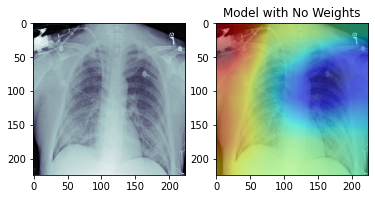

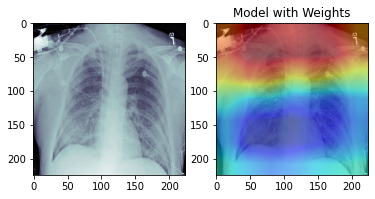

In [86]:
img = val_dataset[-6][0]  # Select a subject
fig = plt.figure()


activation_map, pred = cam(model, img)  # Compute the Class activation map given the subject

visualize(img, activation_map, 'Model with No Weights') # Visualize CAM)

activation_map, pred = cam(model_weighted, img)  # Compute the Class activation map given the subject

visualize(img, activation_map, 'Model with Weights')  # Visualize CAM

We see how "foggy"  region of the x-ray image has a large impact on the prediction of the network. The trained classifier was able to identify both if there was (a) pneumonia or not, and (b) where in the image pneumonia could be found.

torch.Size([1, 512, 1, 1])
torch.Size([512])
torch.Size([1, 512, 1, 1])
torch.Size([512])


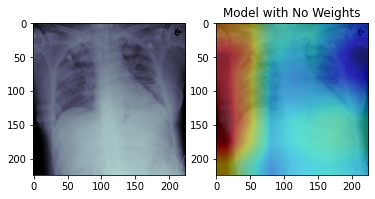

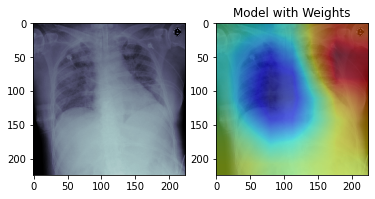

In [87]:
img = val_dataset[-2][0]  # Select a subject

activation_map, pred = cam(model, img)  # Compute the Class activation map given the subject

visualize(img, activation_map, 'Model with No Weights') # Visualize CAM)

activation_map, pred = cam(model_weighted, img)  # Compute the Class activation map given the subject

visualize(img, activation_map, 'Model with Weights')  # Visualize CAM

torch.Size([1, 512, 1, 1])
torch.Size([512])
torch.Size([1, 512, 1, 1])
torch.Size([512])


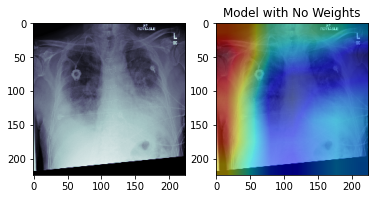

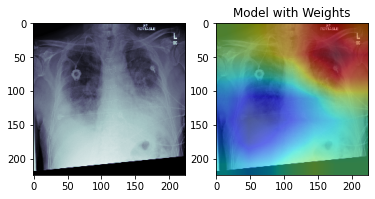

In [88]:
img = val_dataset[-100][0]  # Select a subject

activation_map, pred = cam(model, img)  # Compute the Class activation map given the subject

visualize(img, activation_map, 'Model with No Weights') # Visualize CAM)

activation_map, pred = cam(model_weighted, img)  # Compute the Class activation map given the subject

visualize(img, activation_map, 'Model with Weights')  # Visualize CAM

torch.Size([1, 512, 1, 1])
torch.Size([512])
torch.Size([1, 512, 1, 1])
torch.Size([512])


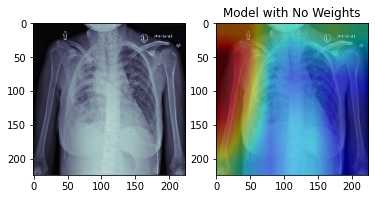

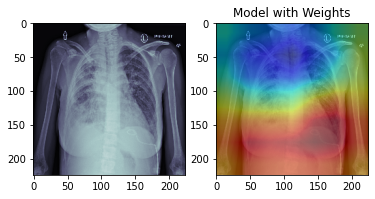

In [89]:
img = val_dataset[-50][0]  # Select a subject

activation_map, pred = cam(model, img)  # Compute the Class activation map given the subject

visualize(img, activation_map, 'Model with No Weights') # Visualize CAM)

activation_map, pred = cam(model_weighted, img)  # Compute the Class activation map given the subject

visualize(img, activation_map, 'Model with Weights')  # Visualize CAM

torch.Size([1, 512, 1, 1])
torch.Size([512])
torch.Size([1, 512, 1, 1])
torch.Size([512])


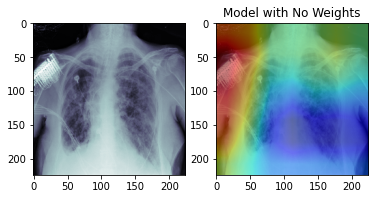

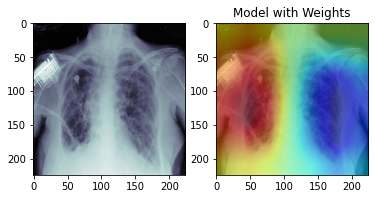

In [90]:
img = val_dataset[-30][0]  # Select a subject

activation_map, pred = cam(model, img)  # Compute the Class activation map given the subject

visualize(img, activation_map, 'Model with No Weights') # Visualize CAM)

activation_map, pred = cam(model_weighted, img)  # Compute the Class activation map given the subject

visualize(img, activation_map, 'Model with Weights')  # Visualize CAM

torch.Size([1, 512, 1, 1])
torch.Size([512])
torch.Size([1, 512, 1, 1])
torch.Size([512])


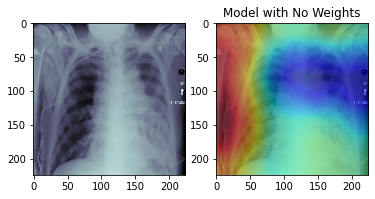

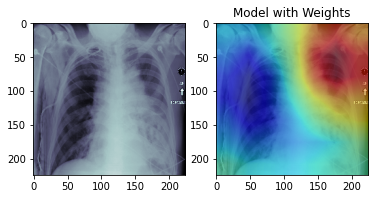

In [91]:
img = val_dataset[-60][0]  # Select a subject

activation_map, pred = cam(model, img)  # Compute the Class activation map given the subject

visualize(img, activation_map, 'Model with No Weights') # Visualize CAM)

activation_map, pred = cam(model_weighted, img)  # Compute the Class activation map given the subject

visualize(img, activation_map, 'Model with Weights')  # Visualize CAM